### Argentina Dataset.

The Global data was using regression models to predict Values using certain crops across Argentina. Unlike the previous two datasets the locations did not seem to affect the R2 scores in the end. Global data and the European data proved to need the countries/locations for better scores. The Argentina data scoreswere only slightly improved when incliuding the individual regions.

The EDA was the most tricky one for this dataset out of all the four datasets. This was mainly because it was all originally in Argentinian Spanish. After translating and replacing the column names with English ones, it was a matter of dropping columns and choosing predictors for predicting the Value output. The predictors chosen were the regions, the crops and the Hectares sown with the chosen crop. 

The Regression models proved to not have too much variance in the R2 scores however the coefficients for the the regularization showed how much the different columns affected the prediction of the Values. It seems that sunflowers (girasol) crop has the most positive effect upon the Value output followed by the region de Formosa. The garlic (ajo) and maiz crops appear to have a large impact as well but it looks it is a negative impact upon the value output.

The Decision Trees and Random forest ressions also appeared to have not made much of an improvement to the score either but it shows a clear binary in the visual data.

The R2 score was above the baseline which shows that the models are able to predict the Value outputs relatively well.

In [1]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNet, ElasticNetCV
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Setting the figure sizes to make sure the graphs are set to the right sizes.

In [3]:
sns.set(rc={'figure.figsize':(40,10),
           'font.size':20})

#### Importing the Dataset and performing general cleaning and removing columns.

In [4]:
# Argentina data + dict

arg = pd.read_csv('./argentina.csv', header=1)
arg_dict = pd.read_csv('./Argy.csv')


In [5]:
arg = arg.drop(columns=['ID Provincia', 'Departamento', 'Id Cultivo', 'ID Campaña'], axis=1)

In [6]:
arg.head(2)

,Provincia,ID Departamento,Cultivo,Campana,Sup. Sembrada (Ha),Sup. Cosechada (Ha),Producción (Tn),Rendimiento (Kg/Ha)
0,BUENOS AIRES,854,Ajo,1969/70,3.0,3.0,10,3.333
1,BUENOS AIRES,854,Ajo,1970/71,1.0,1.0,3,3.000


#### Tedious task of translation and renaming columns.

In [7]:
argy = arg.rename(columns={'Provincia':'Province','Cultivo':'Cultivated','Cultivo':'Date','Sup. Sembrada (Ha)':'Hectares_sown',
                           'Sup. Cosechada (Ha)':'Hectares_Harvested','Producción (Tn)':'Tonnes','Rendimiento (Kg/Ha)':'Harvest_performance'})


In [8]:
arg = argy.drop('ID Departamento', axis =1)
arg.head(2)

,Province,Date,Campana,Hectares_sown,Hectares_Harvested,Tonnes,Harvest_performance
0,BUENOS AIRES,Ajo,1969/70,3.0,3.0,10,3.333
1,BUENOS AIRES,Ajo,1970/71,1.0,1.0,3,3.000


In [9]:
argy = arg.rename(columns={'Date':'Cultivated', 'Campana':'Date'})

In [10]:
arg = argy
arg.head(2)

,Province,Cultivated,Date,Hectares_sown,Hectares_Harvested,Tonnes,Harvest_performance
0,BUENOS AIRES,Ajo,1969/70,3.0,3.0,10,3.333
1,BUENOS AIRES,Ajo,1970/71,1.0,1.0,3,3.000


In [11]:
arg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65498 entries, 0 to 65497
Data columns (total 7 columns):
Province               65498 non-null object
Cultivated             65498 non-null object
Date                   65498 non-null object
Hectares_sown          65498 non-null float64
Hectares_Harvested     65498 non-null float64
Tonnes                 65498 non-null object
Harvest_performance    65498 non-null float64
dtypes: float64(3), object(4)
memory usage: 3.5+ MB


In [12]:
arg.describe(include='all')

,Province,Cultivated,Date,Hectares_sown,Hectares_Harvested,Tonnes,Harvest_performance
count,65498,65498,65498,65498.000000,65498.000000,65498,65498.000000
unique,23,18,48,NaN,NaN,6315,NaN
top,BUENOS AIRES,Avena,1969/70,NaN,NaN,0,NaN
freq,25058,10000,2263,NaN,NaN,11830,NaN
mean,NaN,NaN,NaN,116.068062,102.944777,NaN,143.500810
std,NaN,NaN,NaN,202.662376,196.605316,NaN,294.297989
min,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000
25%,NaN,NaN,NaN,4.000000,1.500000,NaN,1.086250
50%,NaN,NaN,NaN,16.000000,9.000000,NaN,2.100000
75%,NaN,NaN,NaN,110.000000,100.000000,NaN,14.000000


#### Selecting the desired crops that are going to be used in the models.

In [13]:
arg.Cultivated.unique()

array(['Ajo', 'Algodon', 'Alpiste', 'Arroz', 'Avena', 'Banana',
       'Cana de azucar', 'Cartamo', 'Cebada cervecera',
       'Cebada forrajera', 'Cebolla total', 'Centeno', 'Colza', 'Girasol',
       'Jojoba', 'Limon', 'Lino', 'Maiz'], dtype=object)

In [14]:
arg_ = arg[(arg['Cultivated'] == 'Ajo') | (arg['Cultivated'] == 'Maiz') |
          (arg['Cultivated'] == 'Girasol') | (arg['Cultivated'] == 'Cebada Cervecera')]

In [15]:
arg = arg_

In [16]:
arg.head()

,Province,Cultivated,Date,Hectares_sown,Hectares_Harvested,Tonnes,Harvest_performance
0,BUENOS AIRES,Ajo,1969/70,3.0,3.0,10,3.333
1,BUENOS AIRES,Ajo,1970/71,1.0,1.0,3,3.000
2,BUENOS AIRES,Ajo,1969/70,15.0,15.0,82,5.467
3,BUENOS AIRES,Ajo,1970/71,10.0,10.0,55,5.500
4,BUENOS AIRES,Ajo,1971/72,8.0,8.0,44,5.500


#### Seeing  how the different provinces produce different amounts of the crops.

In [17]:
province = arg.groupby('Province')['Hectares_Harvested'].mean()

In [18]:
cou = pd.DataFrame(province)

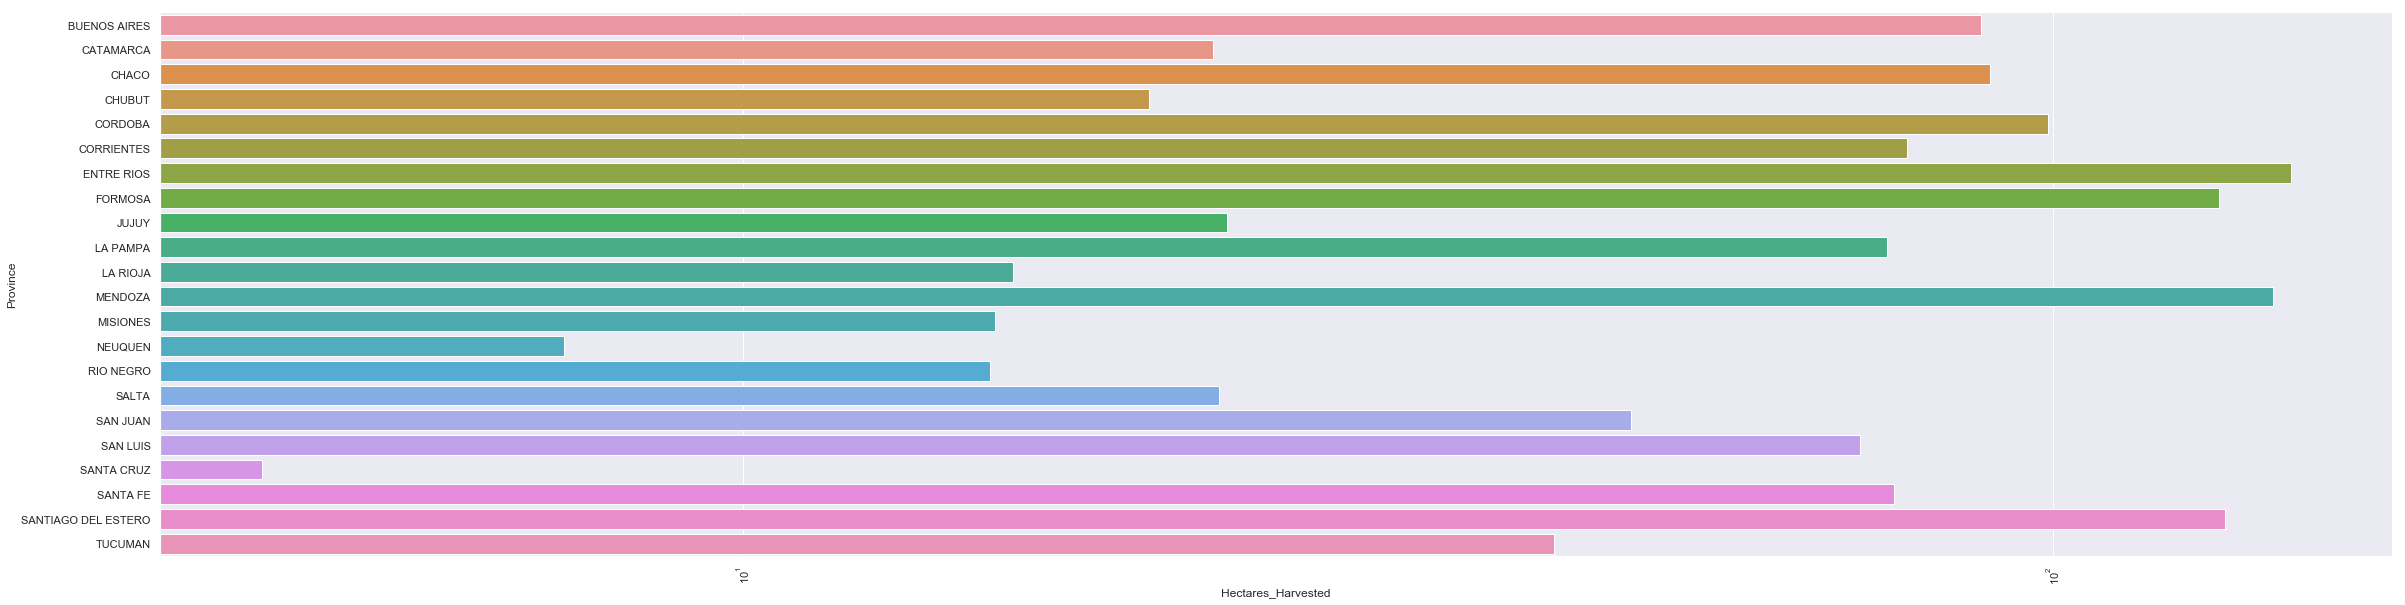

In [19]:
country_graph = sns.barplot(y='Province', x='Hectares_Harvested', data=cou.reset_index(), orient='h', )
country_graph.set(xscale='log')
plt.xticks(rotation=90);

In [20]:
arg.drop('Tonnes', inplace=True, axis = 1)

In [21]:
arg.drop('Date', inplace=True, axis = 1)

#### Dummifying the dataset.

In [22]:
arg_dum = pd.get_dummies(arg, drop_first=True)

In [23]:
arg_dum

,Hectares_sown,Hectares_Harvested,Harvest_performance,Province_CATAMARCA,Province_CHACO,Province_CHUBUT,Province_CORDOBA,Province_CORRIENTES,Province_ENTRE RIOS,Province_FORMOSA,...,Province_RIO NEGRO,Province_SALTA,Province_SAN JUAN,Province_SAN LUIS,Province_SANTA CRUZ,Province_SANTA FE,Province_SANTIAGO DEL ESTERO,Province_TUCUMAN,Cultivated_Girasol,Cultivated_Maiz
0,3.00,3.00,3.333,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.00,1.00,3.000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15.00,15.00,5.467,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10.00,10.00,5.500,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8.00,8.00,5.500,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,8.00,8.00,8.625,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,10.00,10.00,8.500,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,15.00,15.00,8.400,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,15.00,15.00,5.400,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,15.00,15.00,4.067,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
arg_X = arg_dum
arg_y = arg_dum.pop('Harvest_performance')


#### Running a train test split and standardising the desired data and predictors.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(arg_X, arg_y, test_size = 0.33)

In [26]:
model = LinearRegression()
model.fit(X_test, y_test)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [27]:
scaler = StandardScaler()

In [28]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=arg_X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=arg_X.columns)

 #### Setting a function to run the models.

In [29]:
def get_model_scores(model, X_train, y_train, X_test, y_test):
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print("Cross-validated training scores:", scores)
    print("Mean cross-validated training score:", scores.mean())
    model.fit(X_train, y_train)
    print("Training Score:", model.score(X_train, y_train))
    print("Test Score:", model.score(X_test, y_test))
    return model

#### Running a Linear regression and getting the coefficients.

In [30]:
model = LinearRegression()

scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
model.fit(X_train, y_train)
print("Training Score:", model.score(X_train, y_train))
print("Test Score:", model.score(X_test, y_test))  

Cross-validated training scores: [0.16032651 0.13732089 0.13907192 0.16263079 0.12648802]
Mean cross-validated training score: 0.1451676257850552
Training Score: 0.14984396224546537
Test Score: 0.131778239233447


In [31]:
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef

,coefficients,coef_abs
Hectares_sown,-7.914564,7.914564
Hectares_Harvested,9.836503,9.836503
Province_CATAMARCA,15.877927,15.877927
Province_CHACO,12.776042,12.776042
Province_CHUBUT,4.313583,4.313583
Province_CORDOBA,12.533995,12.533995
Province_CORRIENTES,23.779135,23.779135
Province_ENTRE RIOS,13.306498,13.306498
Province_FORMOSA,25.237813,25.237813
Province_JUJUY,6.358907,6.358907


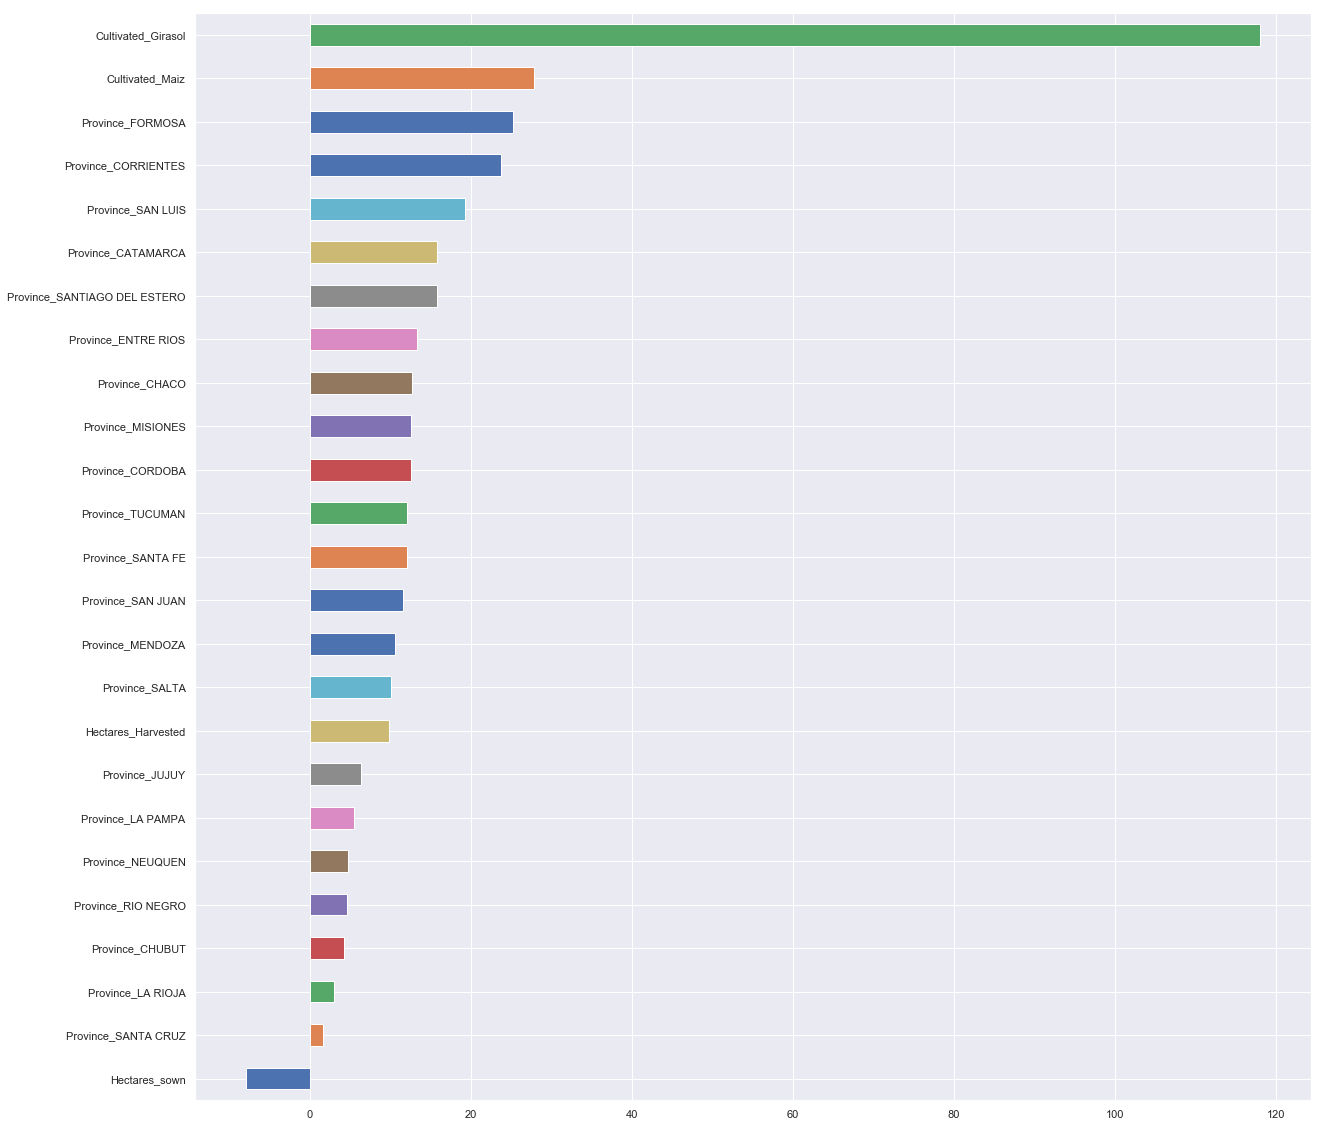

In [32]:
plt.figure(figsize=(20,20))
df_coef['coefficients'].sort_values().plot(kind='barh');

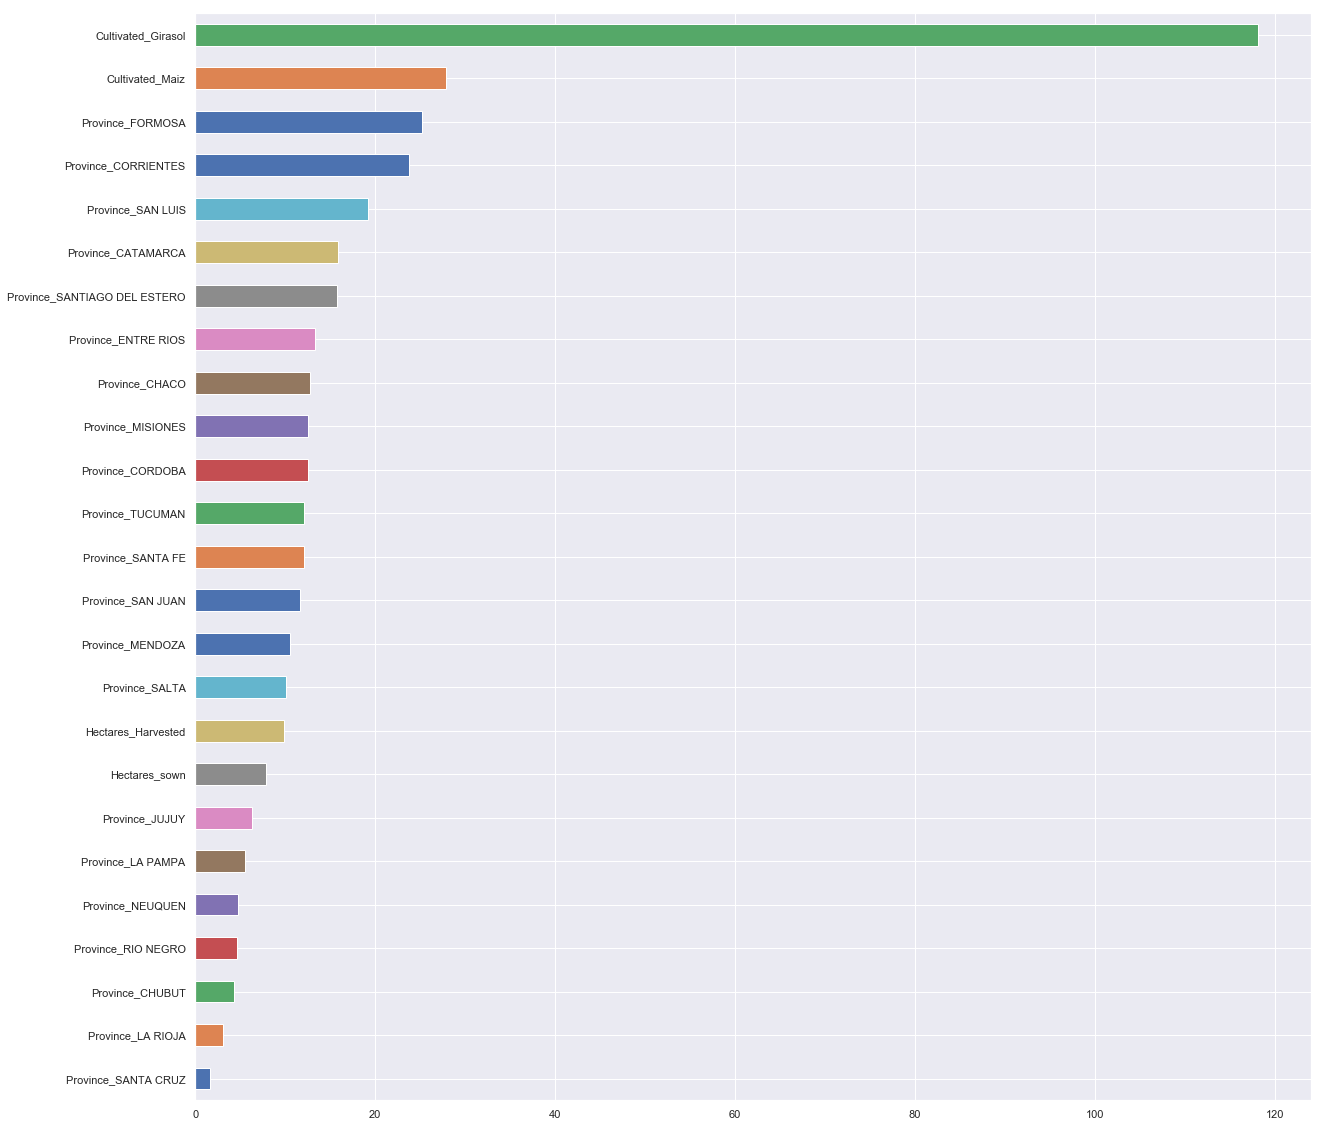

In [33]:
plt.figure(figsize=(20,20))
df_coef['coef_abs'].sort_values().plot(kind='barh');

Looks like we might want to run some regulirization.

#### Regulirization of the models.

#### Running a RidgeCV model.

In [34]:
model = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
model.fit(X_train, y_train)
print('Best alpha:', model.alpha_)
print('Training score:', model.score(X_train, y_train))
print("Test Score:", model.score(X_test, y_test))

Best alpha: 21.54434690031882
Training score: 0.14983974391680255
Test Score: 0.13192159754826127


In [35]:
df_coef1 = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
df_coef1['coef_abs'] = df_coef1.coefficients.abs()
df_coef1

,coefficients,coef_abs
Hectares_sown,-7.779450,7.779450
Hectares_Harvested,9.770607,9.770607
Province_CATAMARCA,15.639129,15.639129
Province_CHACO,12.676809,12.676809
Province_CHUBUT,4.190794,4.190794
Province_CORDOBA,12.388934,12.388934
Province_CORRIENTES,23.577470,23.577470
Province_ENTRE RIOS,13.195832,13.195832
Province_FORMOSA,25.075973,25.075973
Province_JUJUY,6.175454,6.175454


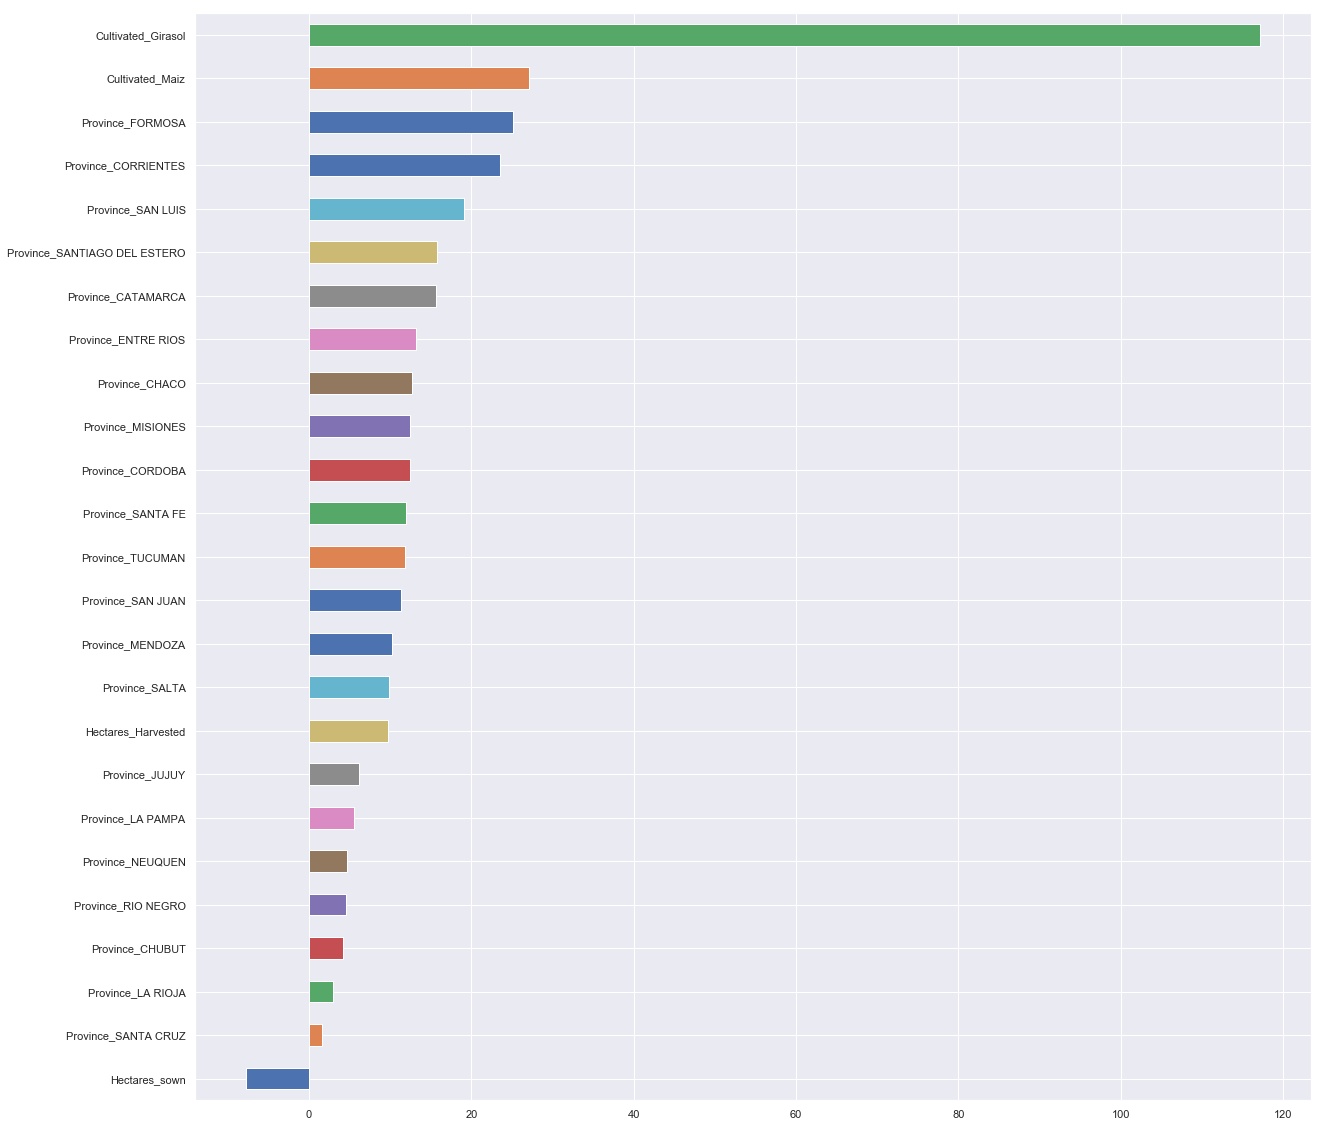

In [36]:
plt.figure(figsize=(20,20))
df_coef1['coefficients'].sort_values().plot(kind='barh');

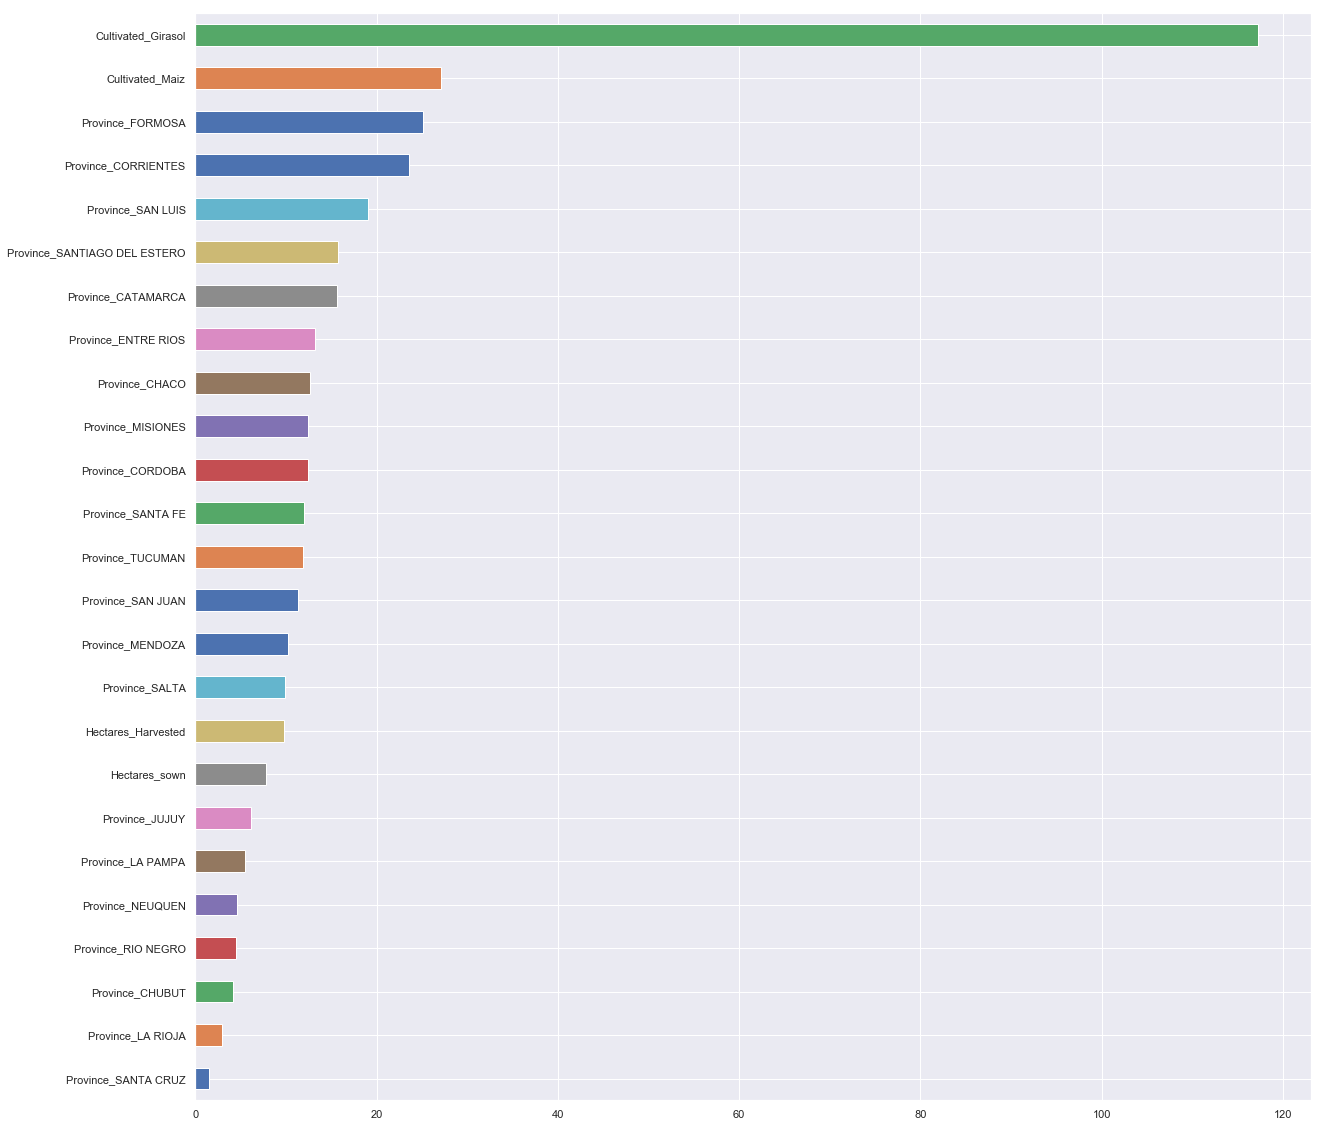

In [37]:
plt.figure(figsize=(20,20))
df_coef1['coef_abs'].sort_values().plot(kind='barh');

#### Running a LassoCV model.

In [38]:
model = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
model.fit(X_train, y_train)
print('Best alpha:', model.alpha_)
print('Training score:', model.score(X_train, y_train))
print("Test Score:", model.score(X_test, y_test))

Best alpha: 0.0001
Training score: 0.1498439622305885
Test Score: 0.13177851149411968


In [39]:
df_coef2 = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
df_coef2['coef_abs'] = df_coef2.coefficients.abs()
df_coef2

,coefficients,coef_abs
Hectares_sown,-7.913916,7.913916
Hectares_Harvested,9.835915,9.835915
Province_CATAMARCA,15.877482,15.877482
Province_CHACO,12.775678,12.775678
Province_CHUBUT,4.313293,4.313293
Province_CORDOBA,12.533587,12.533587
Province_CORRIENTES,23.778746,23.778746
Province_ENTRE RIOS,13.306148,13.306148
Province_FORMOSA,25.237477,25.237477
Province_JUJUY,6.358524,6.358524


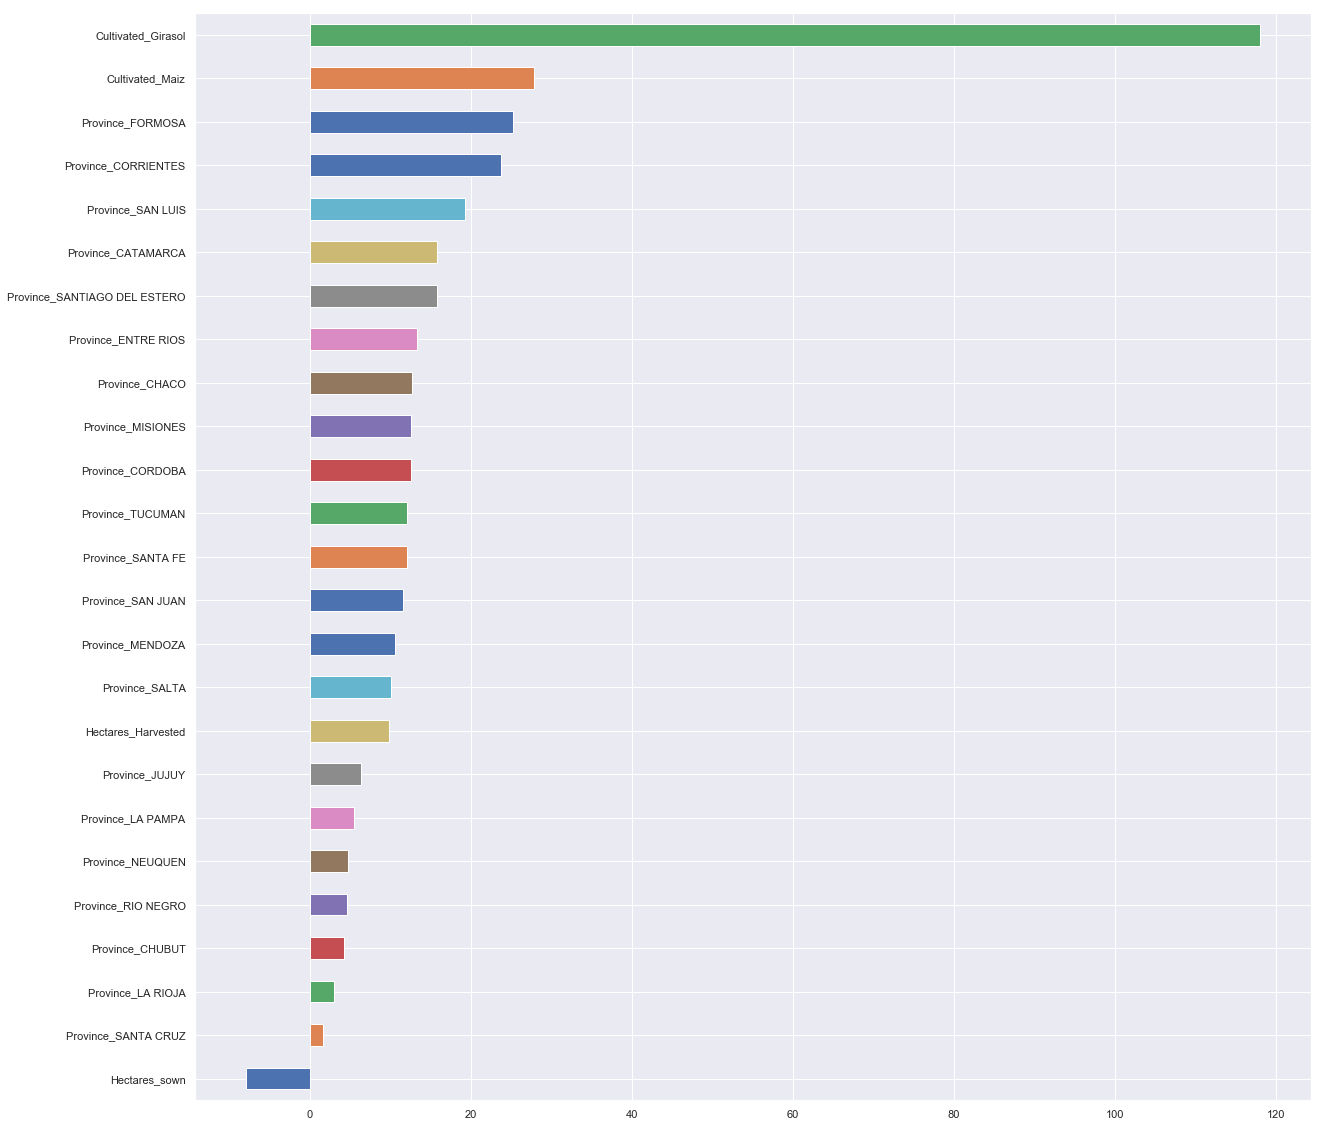

In [40]:
plt.figure(figsize=(20,20))
df_coef2['coefficients'].sort_values().plot(kind='barh');

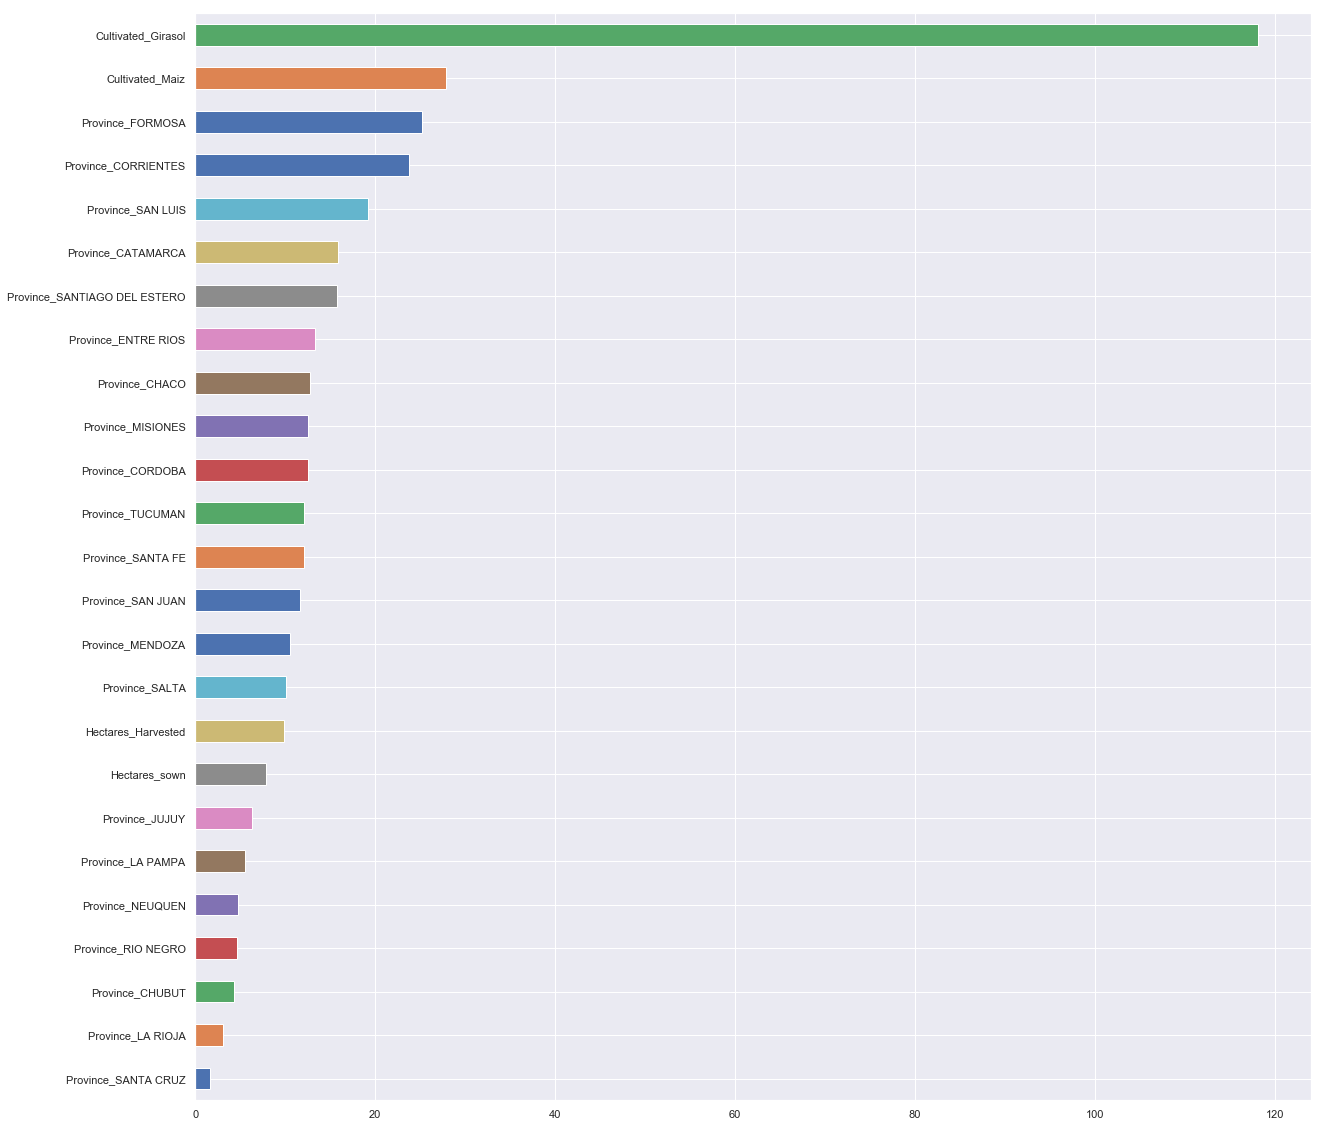

In [41]:
plt.figure(figsize=(20,20))
df_coef2['coef_abs'].sort_values().plot(kind='barh');

#### Running an ElasticNetCV 

In [42]:
model = ElasticNetCV(alphas=np.logspace(-4, 4, 10), cv=5)

In [43]:
model.fit(X_train, y_train)
print('Best alpha:', model.alpha_)
print('Training score:', model.score(X_train, y_train))
print("Test Score:", model.score(X_test, y_test))

Best alpha: 0.005994842503189409
Training score: 0.1498335197210937
Test Score: 0.1320006812233051


In [44]:
df_coef3 = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
df_coef3['coef_abs'] = df_coef3.coefficients.abs()
df_coef3

,coefficients,coef_abs
Hectares_sown,-7.689146,7.689146
Hectares_Harvested,9.718536,9.718536
Province_CATAMARCA,15.500573,15.500573
Province_CHACO,12.614033,12.614033
Province_CHUBUT,4.117808,4.117808
Province_CORDOBA,12.300790,12.300790
Province_CORRIENTES,23.459883,23.459883
Province_ENTRE RIOS,13.127406,13.127406
Province_FORMOSA,24.980839,24.980839
Province_JUJUY,6.067884,6.067884


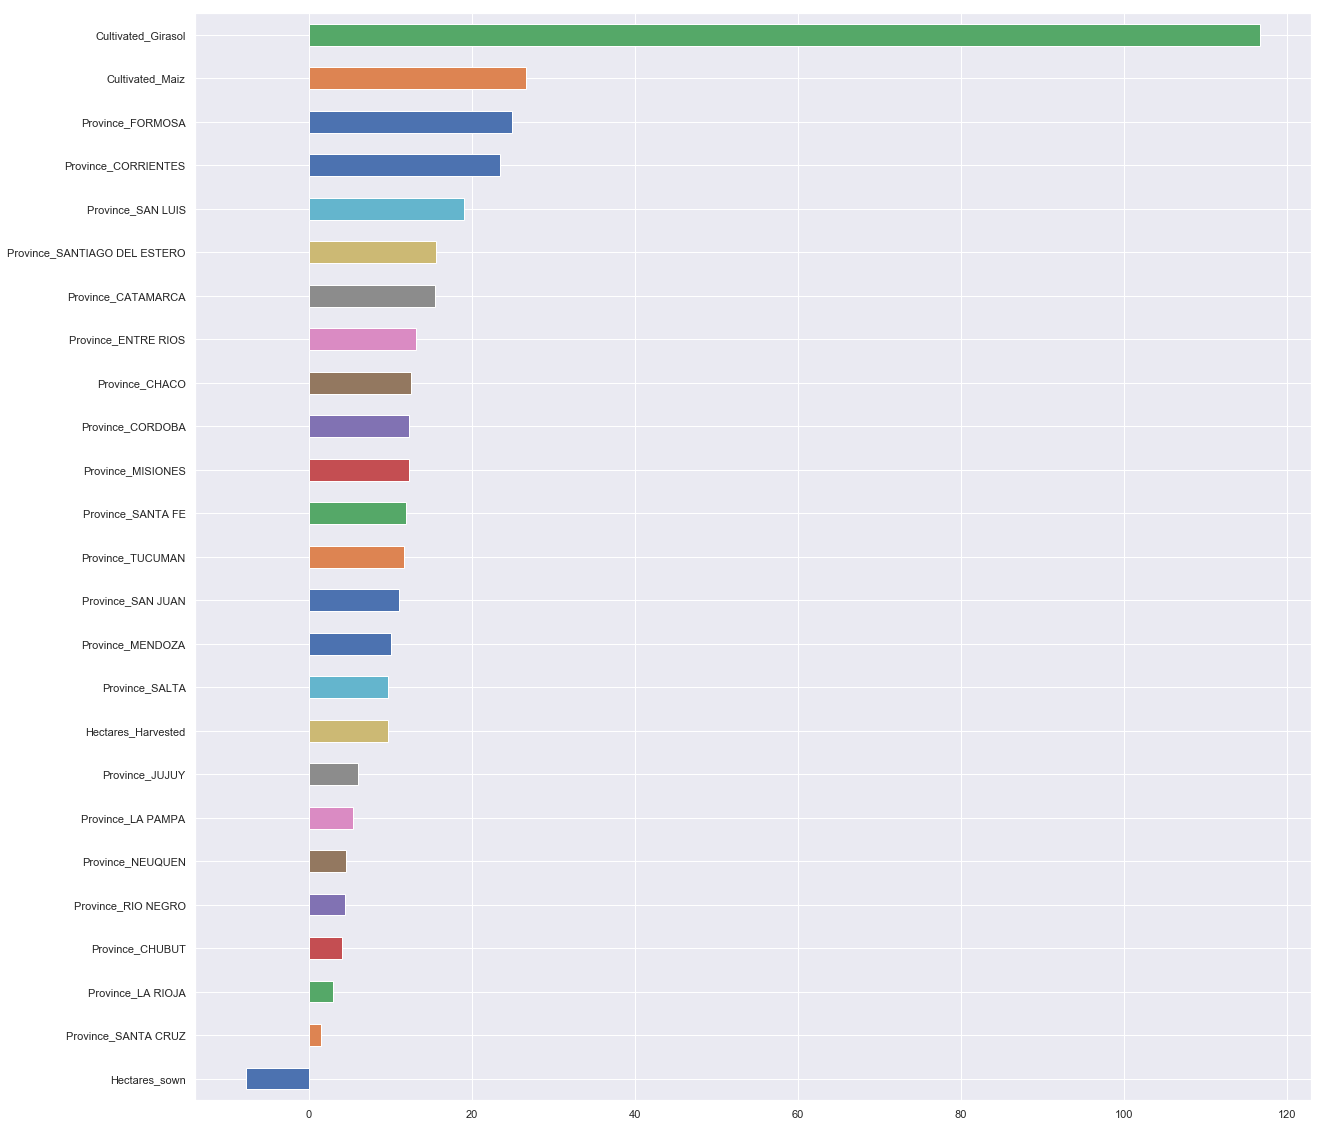

In [45]:
plt.figure(figsize=(20,20))
df_coef3['coefficients'].sort_values().plot(kind='barh');

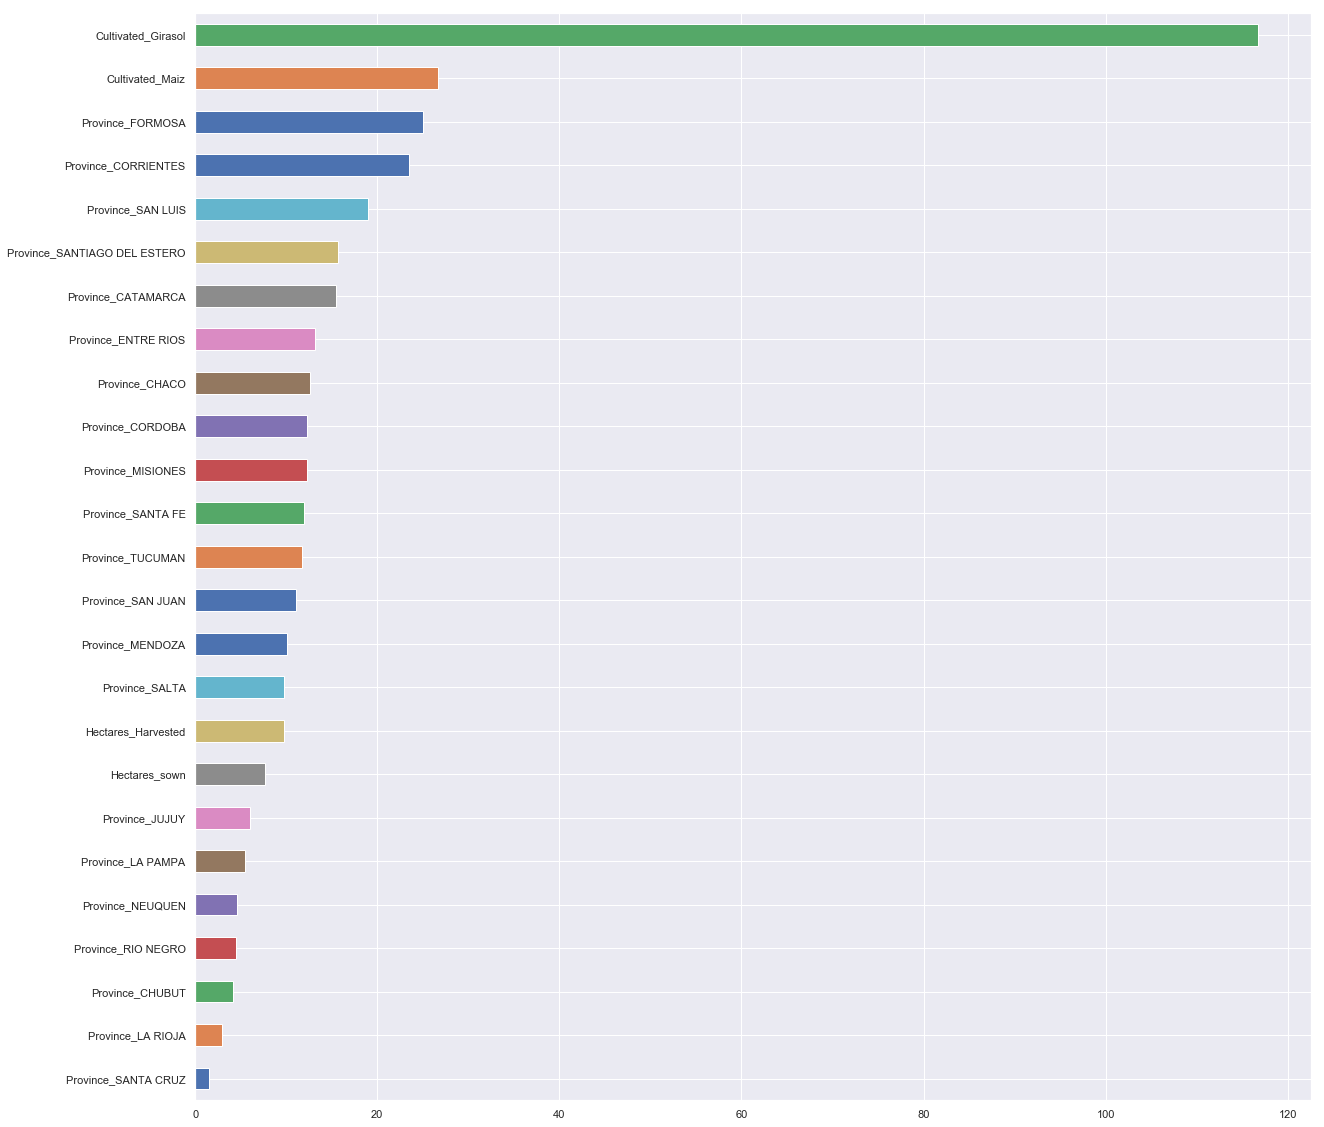

In [46]:
plt.figure(figsize=(20,20))
df_coef3['coef_abs'].sort_values().plot(kind='barh');

### Decision Tree and Random Forest regression

In [47]:
dt = DecisionTreeRegressor(max_depth=5)

In [48]:
get_model_scores(DecisionTreeRegressor(max_depth=5), X_train, y_train, X_test, y_test)

Cross-validated training scores: [0.18034009 0.14100374 0.13915159 0.14823782 0.13650928]
Mean cross-validated training score: 0.14904850494697403
Training Score: 0.16436772531612484
Test Score: 0.13708009169938906


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [49]:
def plot_dt(dt, feature_names=None):
    print('Max depth:', dt.max_depth)
    dot_data = StringIO() 
    export_graphviz(dt, 
                    out_file=dot_data,  
                    filled=True, 
                    rounded=True,
                    special_characters=True,
                    feature_names=feature_names
                   )  

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    return Image(graph.create_png()) 

In [50]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Max depth: 5


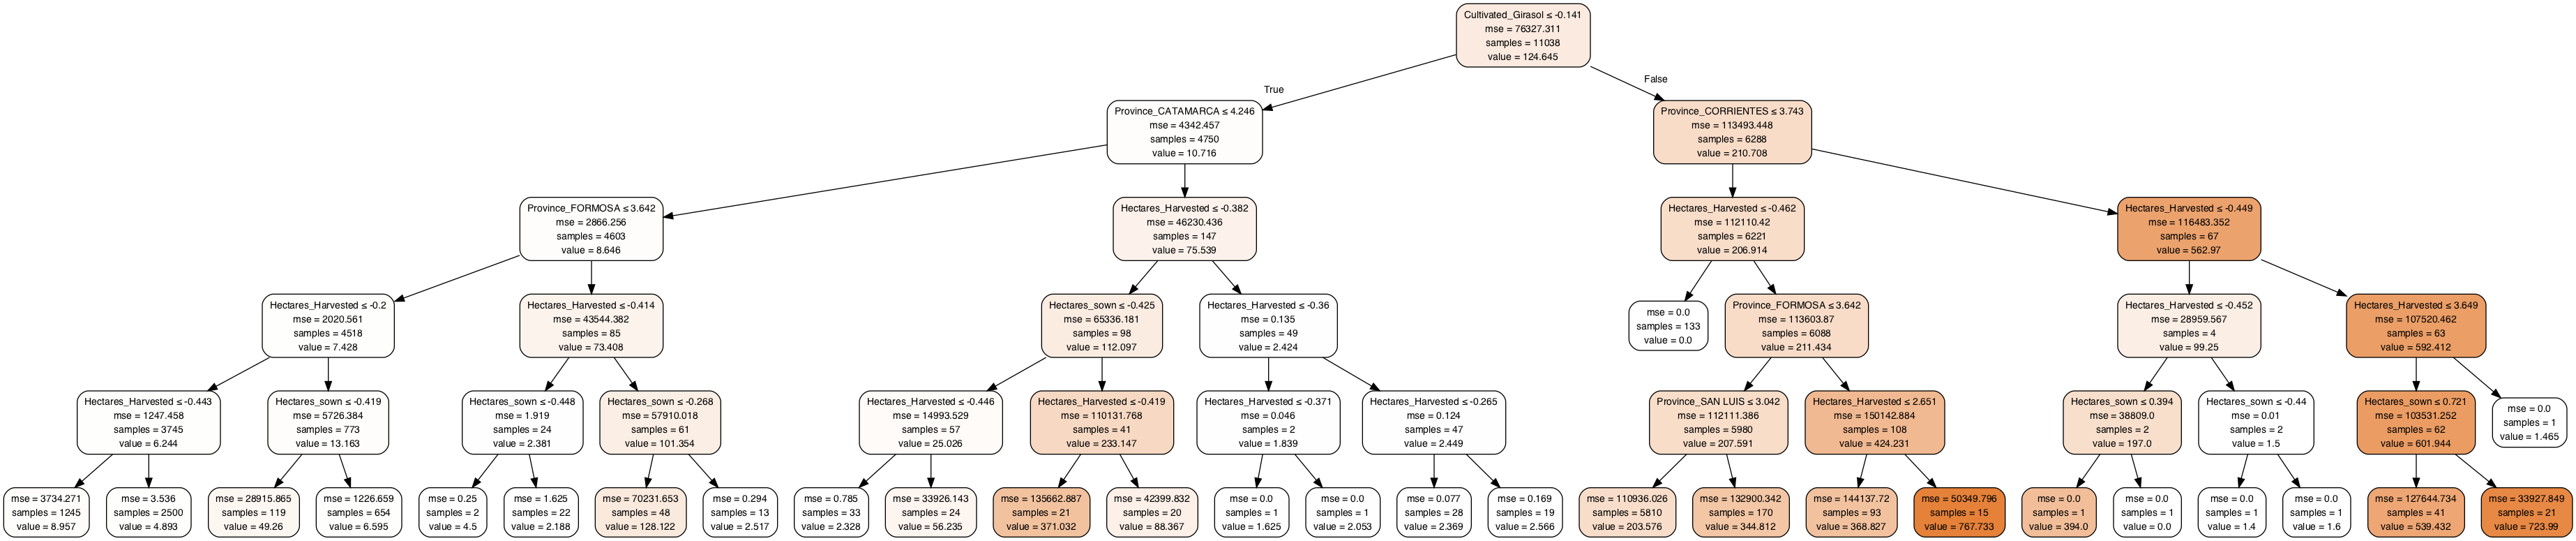

In [51]:
plot_dt(dt, feature_names=arg_X.columns)

In [52]:
kfolds = 5
model = DecisionTreeRegressor(random_state=1)

In [53]:
params = {'max_depth': [1, 2, 3, 4, 5, 6],
          #, 'max_features':[1,2,3,4],
          'max_leaf_nodes': [5, 6, 7, 8, 9, 10],
          'min_samples_leaf': [1, 2, 3, 4]
          #'min_samples_split':[1,2,3,4]
          }

gs = GridSearchCV(model, param_grid=params, cv=kfolds, n_jobs = -1)
gs.fit(X_train, y_train)

model = gs.best_estimator_
print(gs.best_estimator_)
print('R2 training: ', gs.score(X_train, y_train))
print('R2 test: ', gs.score(X_test, y_test))

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')
R2 training:  0.17225327645401634
R2 test:  0.15207882095239167


In [54]:
gs_mse = GridSearchCV(model, param_grid=params, cv=kfolds,
                      scoring='neg_mean_squared_error')
gs_mse.fit(X_train, y_train)

print(gs_mse.best_estimator_)
print('MSE training: ', -gs_mse.score(X_train, y_train))
print('MSE test: ', -gs_mse.score(X_test, y_test))

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')
MSE training:  63179.681428330354
MSE test:  60969.39943323116


In [55]:
arg_y.mean()

122.12048345978769

In [56]:
rmse_train = sqrt(-gs_mse.score(X_train, y_train))

In [57]:
rmse_test = sqrt(-gs_mse.score(X_test, y_test))

In [58]:
print('RMSE train: ', rmse_train)
print('RMSE test: ', rmse_test)
print('Baseline: ', arg_y.mean())
print('std: ', arg_y.std())

RMSE train:  251.35568708173355
RMSE test:  246.919823896809
Baseline:  122.12048345978769
std:  273.65164073416383


In [59]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [60]:
df_coef = pd.DataFrame(model.feature_importances_, index=X_train.columns,
                       columns=['feature importances'])


In [61]:
df_coef_ = pd.DataFrame(lr.coef_, index=X_train.columns,
                       columns=['coefficients'])

In [62]:
df_coef['coef_abs'] = df_coef_.coefficients.abs()


In [63]:
df_coef.sort_values('feature importances', ascending = False)

,feature importances,coef_abs
Cultivated_Girasol,0.745760,118.117605
Hectares_Harvested,0.071289,9.836503
Province_CORRIENTES,0.057906,23.779135
Hectares_sown,0.044554,7.914564
Province_FORMOSA,0.034308,25.237813
Province_SANTIAGO DEL ESTERO,0.023480,15.812050
Province_SAN LUIS,0.022703,19.254322
Province_NEUQUEN,0.000000,4.753017
Province_TUCUMAN,0.000000,12.078367
Province_SANTA FE,0.000000,12.061750


In [64]:
df_coef.corr(method='spearman')

,feature importances,coef_abs
feature importances,1.000000,0.428307
coef_abs,0.428307,1.000000


### Random forest correlations

In [68]:
model_f = RandomForestRegressor(random_state=1)

In [69]:
model_f.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [70]:
df_coef_f = pd.DataFrame(model_f.feature_importances_, index=X_train.columns,
                       columns=['feature importances'])
df_coef_f['coef_abs'] = df_coef_.coefficients.abs()

In [71]:
df_coef_f.sort_values('feature importances', ascending = False)

,feature importances,coef_abs
Hectares_Harvested,3.909807e-01,9.836503
Hectares_sown,2.819846e-01,7.914564
Cultivated_Girasol,1.726574e-01,118.117605
Province_CHACO,2.483608e-02,12.776042
Province_LA PAMPA,2.235807e-02,5.517278
Province_SANTA FE,2.080317e-02,12.061750
Province_ENTRE RIOS,1.861943e-02,13.306498
Province_CORDOBA,1.661490e-02,12.533995
Province_CORRIENTES,1.091527e-02,23.779135
Province_SANTIAGO DEL ESTERO,9.738304e-03,15.812050


In [72]:
df_coef_f.corr(method='spearman')

,feature importances,coef_abs
feature importances,1.000000,0.454615
coef_abs,0.454615,1.000000


In [73]:
df_f = df_coef_f[df_coef_f['feature importances'] > 9e-3]

In [76]:
df_f.sort_values('feature importances', ascending = False)

,feature importances,coef_abs
Hectares_Harvested,0.390981,9.836503
Hectares_sown,0.281985,7.914564
Cultivated_Girasol,0.172657,118.117605
Province_CHACO,0.024836,12.776042
Province_LA PAMPA,0.022358,5.517278
Province_SANTA FE,0.020803,12.061750
Province_ENTRE RIOS,0.018619,13.306498
Province_CORDOBA,0.016615,12.533995
Province_CORRIENTES,0.010915,23.779135
Province_SANTIAGO DEL ESTERO,0.009738,15.812050


In [77]:
df_f.corr(method='spearman')

,feature importances,coef_abs
feature importances,1.000000,-0.454545
coef_abs,-0.454545,1.000000


In [65]:
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

In [66]:
nnet = MLPRegressor(hidden_layer_sizes=(10,10,10),solver='lbfgs',activation='relu',random_state=1)
nnet.fit(X_train,y_train)
metrics.mean_squared_error(y_test,nnet.predict(X_test))

60819.174156325826

In [67]:
nnet.score(X_test,y_test)

0.1541680525193817

In [81]:
colors = df_coef3.coefficients.sort_values(ascending=False).map(lambda x: 'b' if x>0 else 'r').values
colors

array(['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r'],
      dtype=object)

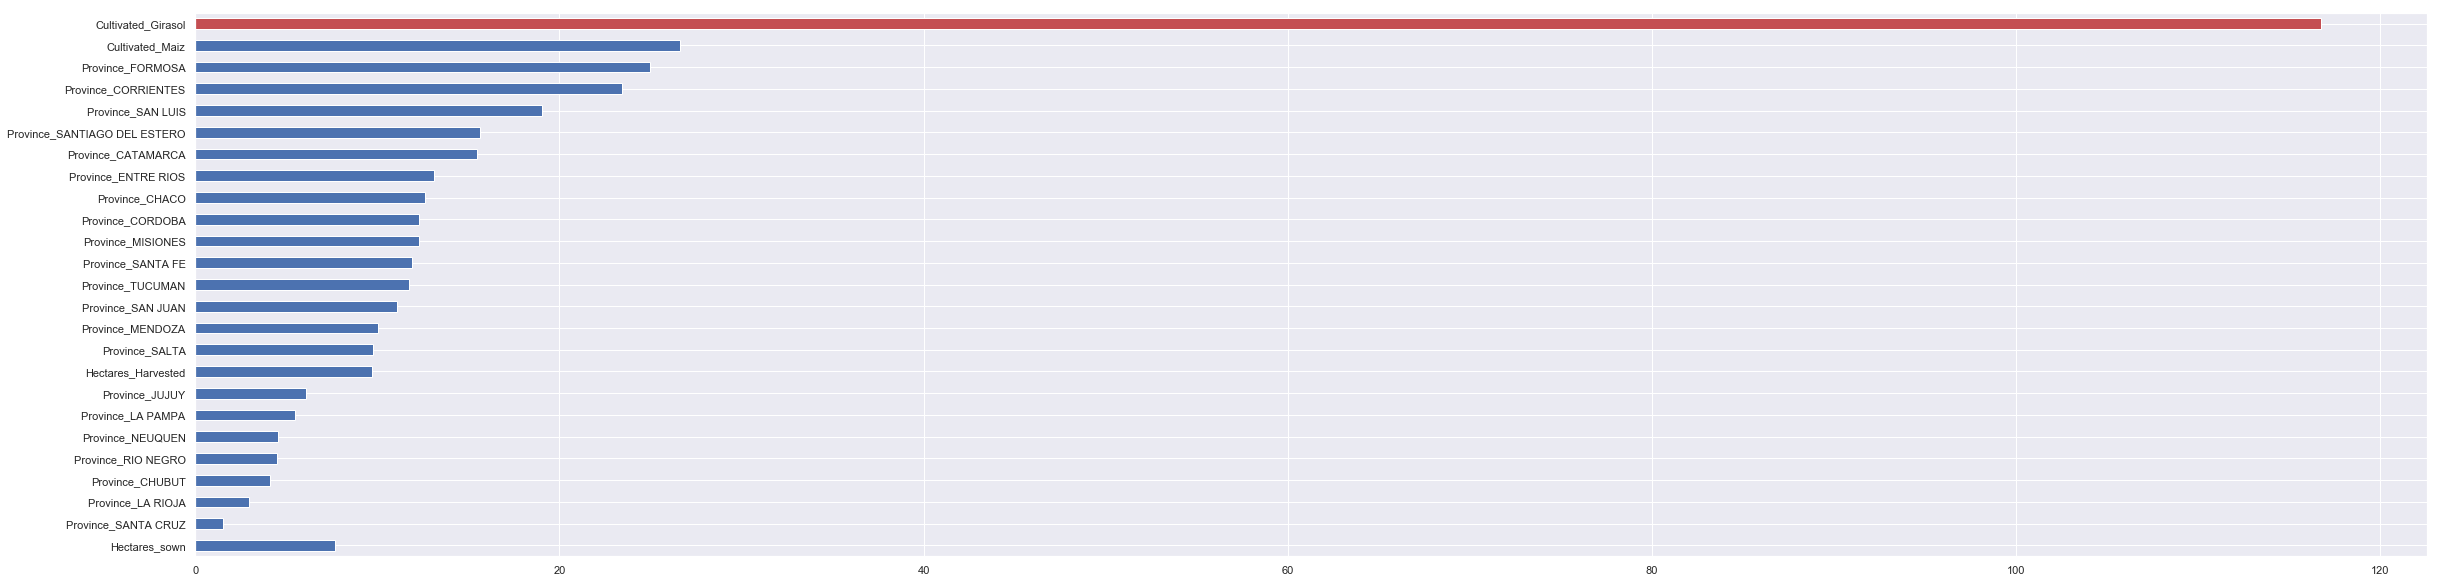

In [84]:
df_coef3.sort_values(by='coefficients').coef_abs.plot(kind='barh',color=colors);